In [1]:
import geopandas as gpd
import pandas as pd
from joblib import Parallel, delayed
import osmnx as ox
import h3
from shapely import Polygon
import json
import contextily
import openrouteservice
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# First step is to produce the boundary of the town
place = 'Barcelona, Spain'
boundary = ox.geocode_to_gdf(place).iloc[0].geometry
client = openrouteservice.Client(base_url='http://localhost:8080/ors')

In [3]:
out = h3.geo_to_cells(boundary,8)
h3_map = pd.DataFrame(out, columns = ['h3_index'])

h3_map['lat'] = h3_map['h3_index'].apply(lambda x: h3.cell_to_latlng(x)[0])
h3_map['lon'] = h3_map['h3_index'].apply(lambda x: h3.cell_to_latlng(x)[1])

In [4]:
with open('src/proxi_API/data/POIS/categories.json', 'r') as file:
    categories = json.load(file)

# Flatten the categories dictionary into a single mapping (amenity -> category)
amenity_to_category = {amenity: category for category, amenities in categories.items() for amenity in amenities}

In [5]:
def get_pois(start, dist, category):
    (lon, lat) = start
    try:
        df = ox.features_from_point((lat, lon), dist = dist, tags = {'amenity':True})
    except:
        df = gpd.GeoDataFrame([], columns = ['geometry','amenity'])
    df = df[['geometry','amenity']]
    df['category'] = df['amenity'].map(amenity_to_category)
    df = df[df['category'] == category]
    df = df.to_crs(epsg=3035)
    df['centroid'] = df.geometry.centroid
    df['lon'] = df.centroid.to_crs(epsg=4326).x
    df['lat'] = df.centroid.to_crs(epsg=4326).y


    return df[['lat','lon','category']].reset_index(drop = True)

In [6]:
def compute_time(start, end, client = client):
    # Format is (lon,lat)
    try:
        route = client.directions(
        coordinates=[start, end],
        profile = 'foot-walking',
        )
        return route['routes'][0]['summary']['duration']
    except: 
        return -1
    


In [7]:
def proximity_time(start, dist = 4000):
    # Format is (lon,lat)
    pois = get_pois(start, dist, 'restaurant')
    pois['time'] = pois.apply(lambda row: compute_time(start, (row.lon,row.lat)), axis = 1)
    pois = pois[pois['time']!=-1]
    return (pois['time'].min())/60

In [ ]:
# Enable TQDM for joblib
tqdm.pandas()

# Function to apply proximity_time on a row
def process_row(row):
    return proximity_time((row.lon, row.lat))

# Parallel apply using Joblib
num_cores = -2  # Use all available cores but one
results = Parallel(n_jobs=num_cores)(
    delayed(process_row)(row) for _, row in tqdm(h3_map.iterrows(), total=len(h3_map))
)

# Assign results back to the DataFrame
h3_map['pt_restaurant'] = results


  0%|          | 0/144 [00:00<?, ?it/s]

 11%|█         | 16/144 [00:05<01:03,  2.01it/s]

In [ ]:
def h3_to_polygon(h3_index):
    boundary = h3.cell_to_boundary(h3_index)  # Returns list of (lat, lon)
    boundary = [(lon, lat) for lat, lon in boundary]  # Swap to (lon, lat)
    return Polygon(boundary)

df = h3_map.copy()
# Create a GeoDataFrame
df['geometry'] = df['h3_index'].apply(h3_to_polygon)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set Coordinate Reference System (CRS)
gdf.set_crs(epsg=4326, inplace=True)  # WGS 84

AttributeError: 'NoneType' object has no attribute 'copy'

,h3_index,lat,lon,pt_restaurant,geometry
0,873944600ffffff,41.403638,2.135188,0.386667,"POLYGON ((2.11999 41.40761, 2.12229 41.39517, ..."
1,873944628ffffff,41.449945,2.184513,9.708333,"POLYGON ((2.1693 41.45392, 2.1716 41.44148, 2...."
2,873944631ffffff,41.415554,2.089582,11.681667,"POLYGON ((2.07438 41.41952, 2.07669 41.40708, ..."
3,873944605ffffff,41.424548,2.145784,2.595000,"POLYGON ((2.13058 41.42852, 2.13288 41.41608, ..."
4,87394460effffff,41.391698,2.180801,0.808333,"POLYGON ((2.1656 41.39568, 2.1679 41.38323, 2...."
5,873944601ffffff,41.408127,2.163295,1.041667,"POLYGON ((2.14809 41.41211, 2.15039 41.39966, ..."
6,87394461cffffff,41.366300,2.142101,3.321667,"POLYGON ((2.1269 41.37028, 2.12921 41.35783, 2..."
7,873944606ffffff,41.399143,2.107092,9.110000,"POLYGON ((2.09189 41.40311, 2.0942 41.39067, 2..."
8,87394462effffff,41.445457,2.156386,13.516667,"POLYGON ((2.14117 41.44943, 2.14348 41.43699, ..."
9,873944618ffffff,41.349868,2.159600,7.133333,"POLYGON ((2.1444 41.35385, 2.14671 41.3414, 2...."


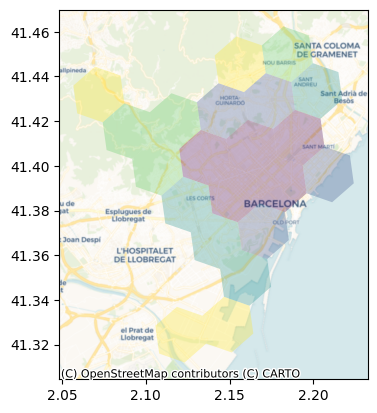

In [ ]:
fig, ax = plt.subplots()
gdf.plot('pt_restaurant', scheme = 'quantiles', ax = ax, alpha = 0.5)
contextily.add_basemap(ax, crs = gdf.crs.to_string(), source=contextily.providers.CartoDB.Voyager)